In [ ]:
#we now need to dig into why you are getting different results from previous attempts at analysis. 
#next consideration is how well are we modeling the events. for this, let's focus on the nonword 
#repetition task and narrow things down. to simplify things, just create multiple contrast images 
#offsetting the onsets through a range of durations: -3, -2,  -1, 0 (current), 1, 2, 3.  start 
#with a single subject, single run, and see how that subject's map changes for speaking vs baseline.

In [1]:
#Import packages
import os
import glob
import json
#from tqdm import tqdm

import nilearn
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix, run_glm
from nilearn.glm import fdr_threshold,threshold_stats_img
from nilearn.glm.contrasts import compute_contrast


from bids.layout import BIDSLayout, parse_file_entities

# import cortex
# from cortex import fmriprep

from nipype.interfaces.workbench.base import WBCommand
from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

import hcp_utils as hcp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

#%matplotlib inline
#! module load openmind/hcp-workbench/1.2.3

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


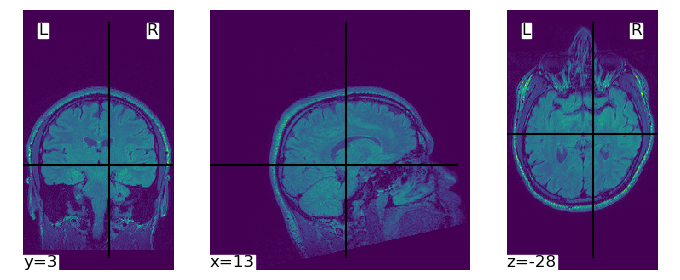

In [6]:
nplot.plot_img(nimg.load_img('../../sub-voice880/ses-1/anat/sub-voice880_ses-1_T2w.nii.gz'))

In [12]:
#root = '/nese/mit/group/sig/om_projects/voice/bids/data'
root = '../../derivatives/events_sweep'
sub = 'voice880'
ses = '1'
task = 'nwr'
run = '1'
events_file = [f'{root}/sub-{sub}_ses-{ses}_task-{task}_run-0{run}_events.tsv']
base_events = pd.read_table(events_file[0])

In [13]:
all_confounds = pd.read_csv(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')
len([col for col in all_confounds.columns if 'a_comp_cor' in col])

12

In [14]:
shift = np.arange(-3,4)
shift_tags = [f'shift{s}' for s in shift]
shift_tags

['shift-3', 'shift-2', 'shift-1', 'shift0', 'shift1', 'shift2', 'shift3']

In [15]:
TR = 4
for s in shift:
    #if s != 0: #skip 0 shift since we already have this file
    ev = pd.read_table(events_file[0])
    #ev['onset'] = ev.onset - ev.duration*s
    ev['onset'] = ev.onset - TR*s
    ev.to_csv(f'{root}/sub-{sub}-shift{s}_ses-{ses}_task-{task}_run-0{run}_events.tsv', sep="\t", index=False)



In [16]:
shifted_events = glob.glob(f'{root}/*shift*.tsv')
shifted_events

['../../derivatives/events_sweep/sub-voice880-shift-1_ses-1_task-nwr_run-01_events.tsv',
 '../../derivatives/events_sweep/sub-voice880-shift-2_ses-1_task-nwr_run-01_events.tsv',
 '../../derivatives/events_sweep/sub-voice880-shift-3_ses-1_task-nwr_run-01_events.tsv',
 '../../derivatives/events_sweep/sub-voice880-shift0_ses-1_task-nwr_run-01_events.tsv',
 '../../derivatives/events_sweep/sub-voice880-shift1_ses-1_task-nwr_run-01_events.tsv',
 '../../derivatives/events_sweep/sub-voice880-shift2_ses-1_task-nwr_run-01_events.tsv',
 '../../derivatives/events_sweep/sub-voice880-shift3_ses-1_task-nwr_run-01_events.tsv']

In [46]:
pd.read_table('../../derivatives/events_sweep/sub-voice880-shift-3_ses-1_task-nwr_run-01_events.tsv').head()

,onset,duration,trial_type,nonword
0,12.00,1.1,4,nuplarative
1,16.02,1.1,4,allotastry
2,20.03,1.1,5,ionificate
3,24.05,1.1,5,uninagable
4,28.07,1.1,Rest,NaN


<Axes: label='conditions', ylabel='scan number'>

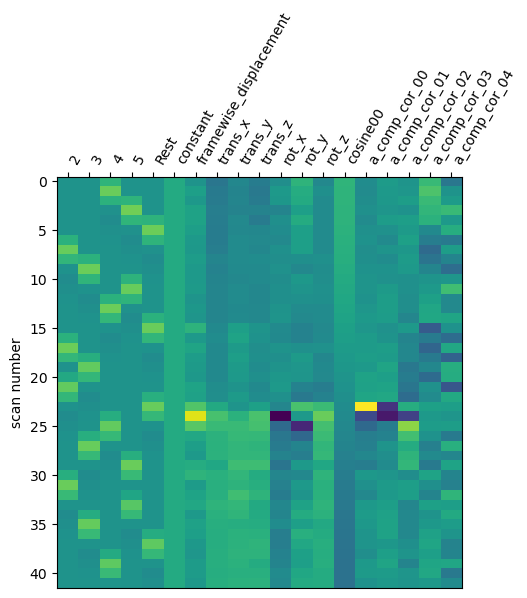

In [53]:
nilearn.plotting.plot_design_matrix(design_matrix)

In [49]:
[shifted_events[4]]

'../../derivatives/events_sweep/sub-voice880-shift1_ses-1_task-nwr_run-01_events.tsv'

In [56]:
shifted_betas = {}
return_type = 'z_score'

for shev in shifted_events:
#for shev in [shifted_events[4]]:
    bids_item = [parse_file_entities(shev)]
    name = shev.split('events_sweep/')[1].split('_events')[0] #remove nondescriptive path info
    shifted_betas[name] = convolve_sparse_scan_glm_with_cifti(bids_item, [shev], return_type=return_type)
    #shifted_betas[name], design_matrix = convolve_sparse_scan_glm_with_cifti(bids_item, [shev], return_type=return_type)
shifted_betas_df = pd.DataFrame({n: [v[0] for v in b.to_numpy()] for n,b in shifted_betas.items()})

/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


230928-14:36:25,49 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:25,51 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:25,52 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:36:25,55 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:25,58 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:25,58 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:36:25,62 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:25,64 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:25,65 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:36:25,68 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:25,71 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:25,71 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:36:25,75 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:25,77 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:25,77 nipype.interface IN

/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


230928-14:36:43,216 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:43,219 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:43,219 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:36:43,223 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:43,225 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:43,226 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:36:43,229 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:43,231 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:43,232 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:36:43,235 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:43,238 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:43,238 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:36:43,242 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:36:43,244 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:36:43,244 nipy

/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


230928-14:37:01,269 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:01,272 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:01,272 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:01,276 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:01,278 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:01,279 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:01,283 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:01,284 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:01,285 nipype.interface INFO:
	 reg_scale: 43.1973


/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


230928-14:37:19,204 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:19,206 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:19,207 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:19,210 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:19,212 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:19,213 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:19,215 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:19,216 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:19,217 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:19,219 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:19,221 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:19,221 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:19,223 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:19,225 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:19,225 nipy

/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


230928-14:37:37,391 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:37,393 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:37,393 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:37,397 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:37,399 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:37,399 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:37,403 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:37,405 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:37,405 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:37,409 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:37,411 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:37,412 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:37,415 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:37,417 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:37,418 nipy

/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


230928-14:37:55,225 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:55,227 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:55,227 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:55,230 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:55,231 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:55,231 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:55,234 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:55,235 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:55,236 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:55,238 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:55,239 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:55,240 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:37:55,242 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:37:55,244 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:37:55,244 nipy

/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


230928-14:38:13,330 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:38:13,332 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:38:13,333 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:38:13,336 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:38:13,339 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:38:13,340 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:38:13,343 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:38:13,345 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:38:13,346 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:38:13,349 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:38:13,351 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:38:13,352 nipype.interface INFO:
	 reg_scale: 43.1973
230928-14:38:13,355 nipype.interface INFO:
	 Setting dt = 110 ms

230928-14:38:13,357 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
230928-14:38:13,358 nipy

/om2/user/rfbrito/miniconda/envs/imaging_with_statsmodel/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `nonword` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "


In [57]:
shifted_betas_df

,sub-voice880-shift-1_ses-1_task-nwr_run-01,sub-voice880-shift-2_ses-1_task-nwr_run-01,sub-voice880-shift-3_ses-1_task-nwr_run-01,sub-voice880-shift0_ses-1_task-nwr_run-01,sub-voice880-shift1_ses-1_task-nwr_run-01,sub-voice880-shift2_ses-1_task-nwr_run-01,sub-voice880-shift3_ses-1_task-nwr_run-01
0,1.691407,0.840266,0.029841,2.055264,1.304917,-0.455947,-0.695285
1,-0.047632,-0.179397,-1.952384,-0.836988,0.443801,1.690748,3.312443
2,2.597087,-0.917440,-1.158037,6.465061,2.052712,-0.973016,-1.723375
3,0.975991,-0.545179,-1.055600,2.145024,2.301246,1.277653,0.505754
4,0.649020,-0.383118,-0.091059,0.438165,-0.667987,-0.253007,2.180280
...,...,...,...,...,...,...,...
91277,-0.413019,-0.362684,-0.557138,-0.634249,-0.968328,-0.162254,0.506893
91278,-2.257670,-1.599816,-1.030767,-0.598285,0.295843,0.380054,0.438257
91279,-2.089110,-1.174776,-0.480798,-0.597180,-0.007705,0.620313,0.385201
91280,-0.648564,-0.654098,-0.583527,-0.255593,-0.588749,0.200702,0.376192


In [59]:
#vmax = shifted_betas_df.max().max()
vmax = 3
for c in shifted_betas_df.columns:
    
    title = c.split('shift')[1].split('_ses')[0]
    nplot.plot_surf_stat_map(
        hcp.mesh.inflated, hcp.cortex_data(shifted_betas_df[c]), hemi='left', #threshold=thresholds[c],
        symmetric_cbar = False,
        colorbar=False,
        title = f'{title}, LH, {return_type}', output_file=f'{root}/{c}_hemi-LH_view-lateral.png',
        title_font_size=30, vmax = vmax,
        bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
        hcp.mesh.inflated_left, hcp.left_cortex_data(shifted_betas_df[c]), view= 'lateral',
        hemi='right', #threshold=thresholds[c],
        symmetric_cbar = False, output_file=f'{root}/{c}_hemi-LH_view-medial.png',
        colorbar=False, vmax = vmax,  
        bg_map=hcp.mesh.sulc_left)

    nplot.plot_surf_stat_map(
        hcp.mesh.inflated, hcp.cortex_data(shifted_betas_df[c]), hemi='right', #threshold=thresholds[covariate],
        symmetric_cbar = False, output_file=f'{root}/{c}_hemi-RH_view-lateral.png',
        colorbar=False,
        title = f'{title}, RH, {return_type}', vmax = vmax,
        bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
        hcp.mesh.inflated_right, hcp.left_cortex_data(shifted_betas_df[c]), view= 'lateral',
        hemi='left', #threshold=thresholds[covariate],
        symmetric_cbar = False, output_file=f'{root}/{c}_hemi-RH_view-medial.png',
        colorbar=False, vmax = vmax,
        bg_map=hcp.mesh.sulc_right)

    #nplot.show()

In [60]:
for sl in shift_tags:
    imgs = glob.glob(f'{root}/*{sl}*.png')
    combine_images(images = imgs, columns=1, space = 1, out_file=f'{root}/{sl}.png')
#[glob.glob(f'{root}/*{sl}*.png') for sl in shift_tags]

In [61]:
img_col = [f'{root}/{st}.png' for st in shift_tags]
combine_images(images = img_col, columns=len(img_col), space = 1, out_file=f'{root}/event_shift.png')

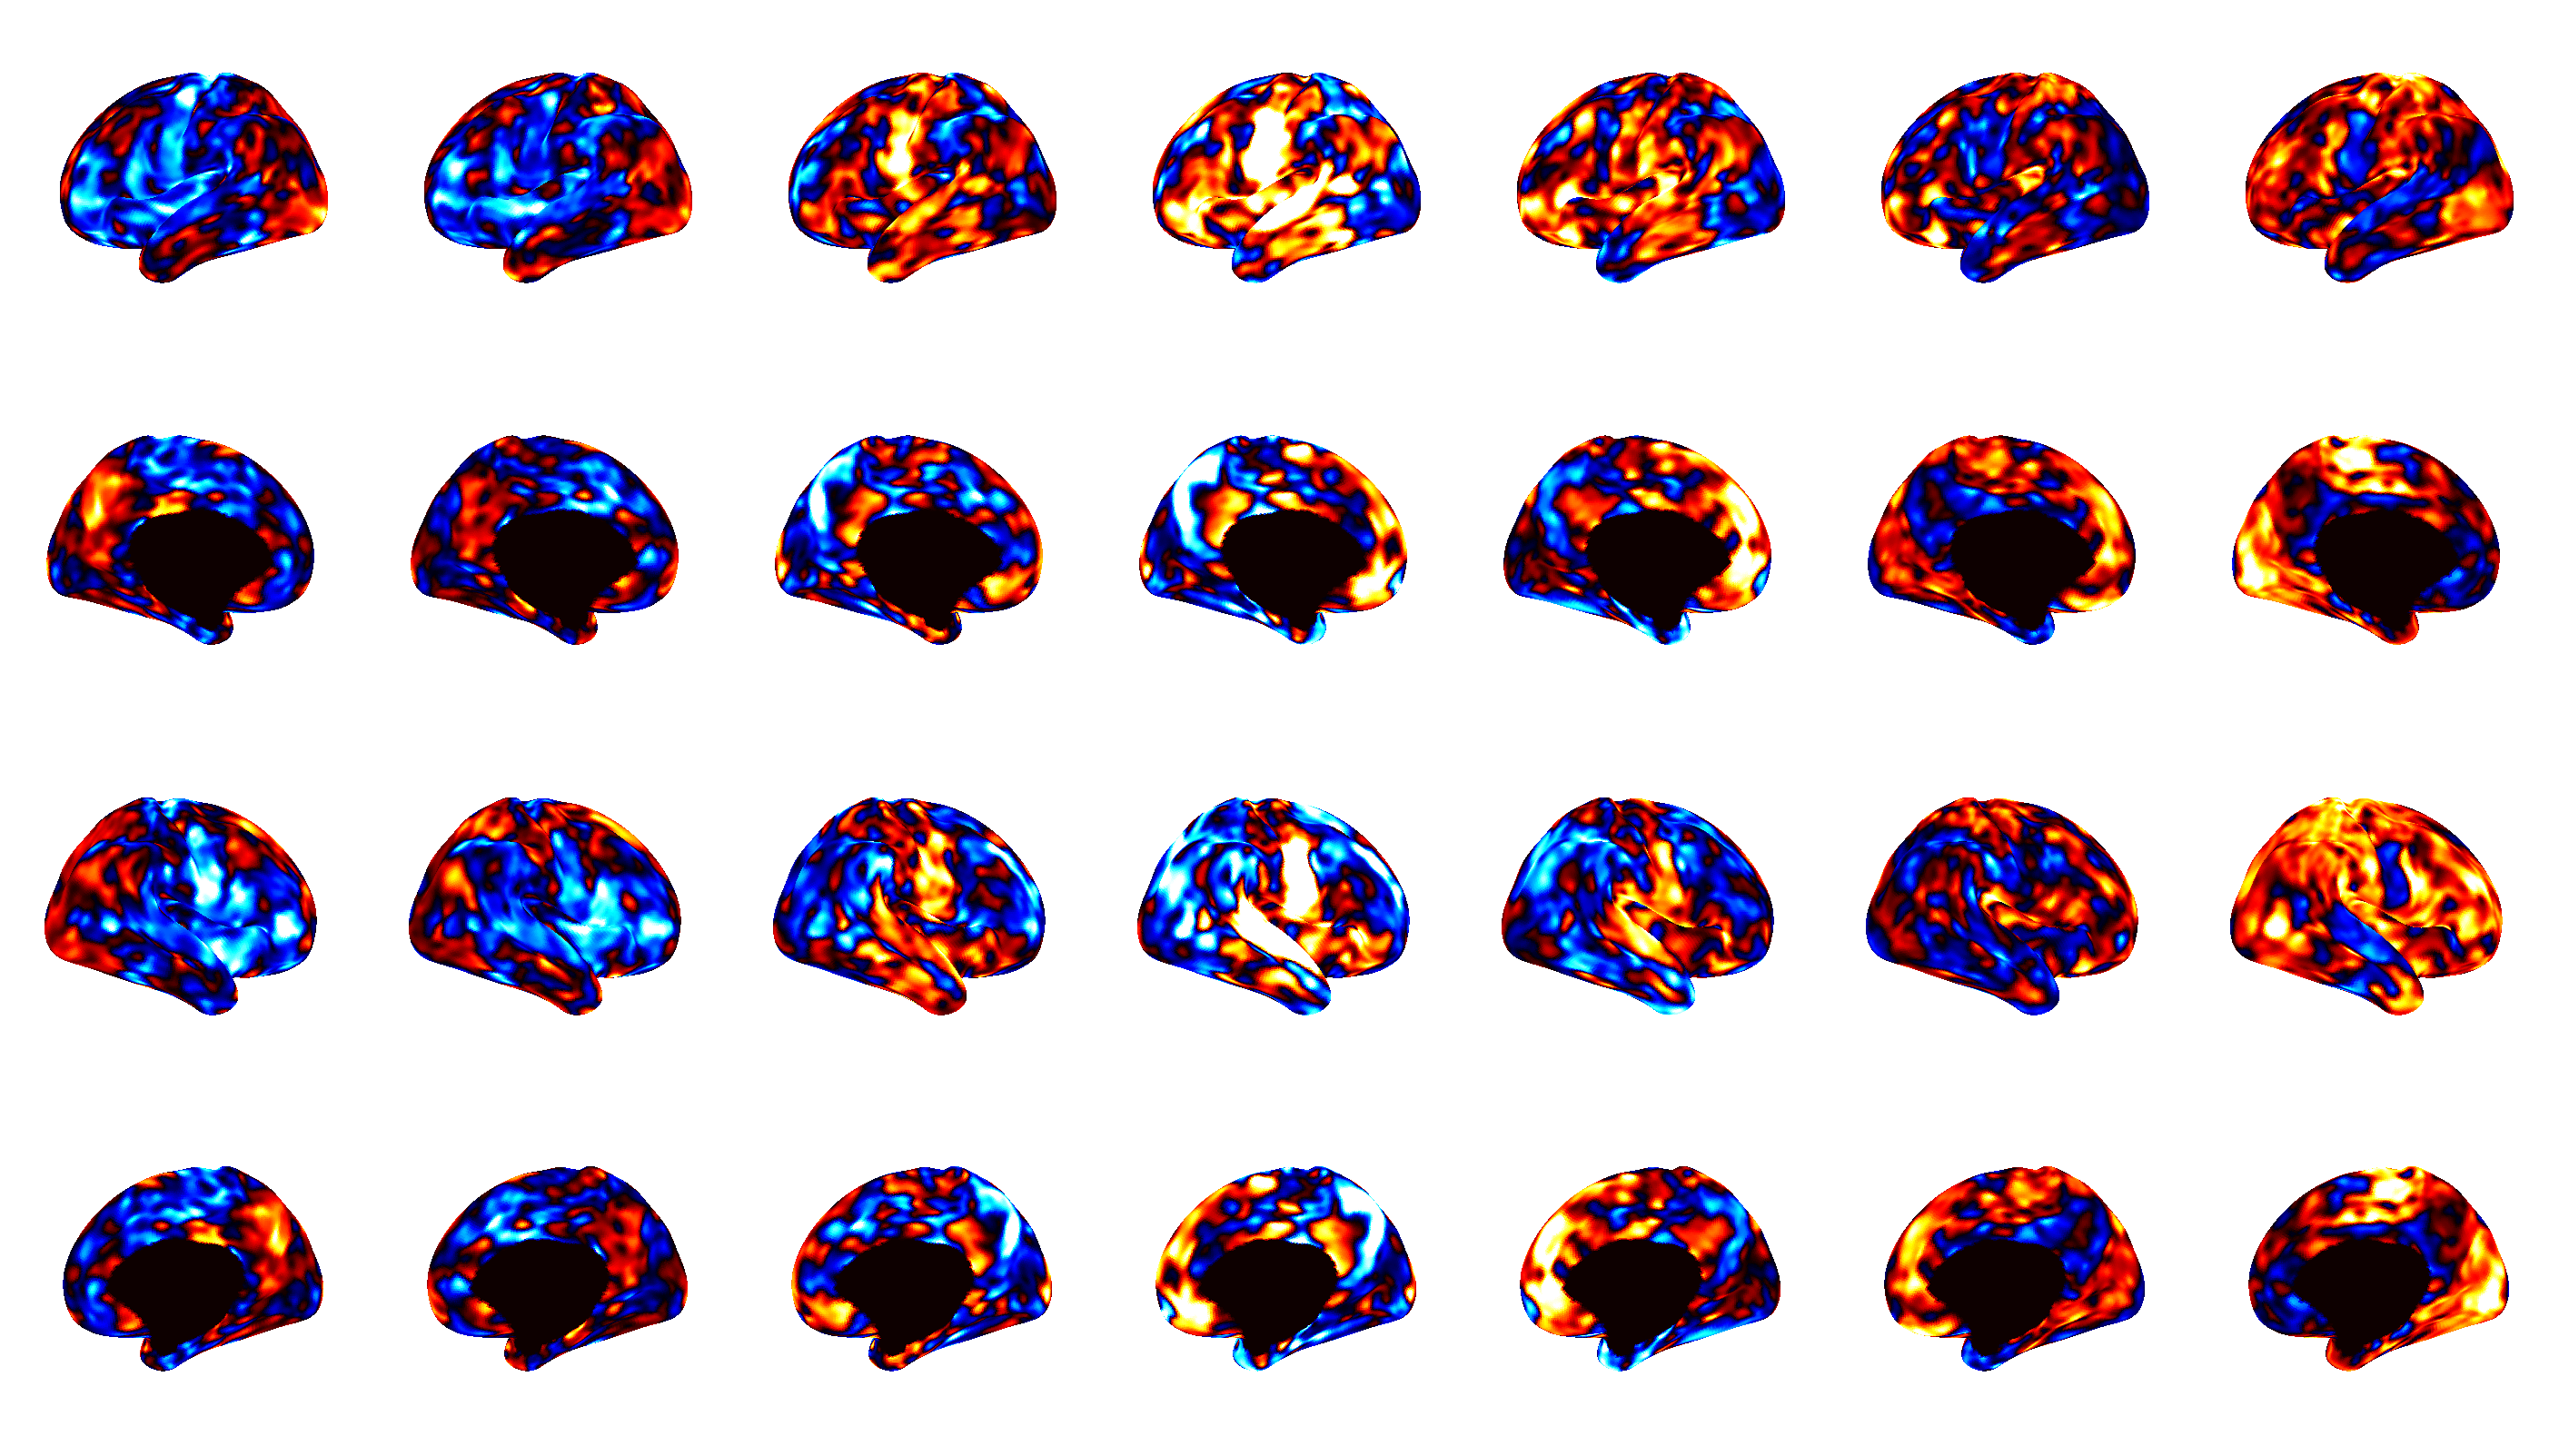

In [62]:
Image.open(f'{root}/event_shift.png')
#Image.open(f'{root}/{sl}.png')
#Image.open(f'{root}/{c}_hemi-LH_view-medial.png')


In [19]:
def combine_images(images, columns, space, out_file):
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1
    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0
    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width)/2)
        y_offset = int((height_max-img.height)/2)
        background.paste(img, (x+x_offset, y+y_offset))
        x += width_max + space
        if (i+1) % columns == 0:
            y += height_max + space
            x = 0
    background.save(out_file)




In [63]:
bids_item

[{'subject': 'voice880',
  'session': '1',
  'task': 'nwr',
  'run': 01,
  'suffix': 'events',
  'extension': '.tsv'}]

In [55]:
def convolve_sparse_scan_glm_with_cifti(parsed_valid_runs, events, return_type):
    #parsed_valid_runs: in the below format which bids.layout.parse_file_entities()
    #outputs when given a path to a BIDs item like an events file or image
    #
    #     [{'subject': 'voice880',
    #   'session': '1',
    #   'task': 'nwr',
    #   'run': 01,
    #   'suffix': 'events',
    #   'extension': '.tsv'}]
    
    #events: the events file for this run
    #it is a parameter for testing so I can input different events files
    #for different TR shifts
    
    #return type: a valid output type from  nilearn.glm.contrasts.compute_contrast
    #'effect_size':
    #'z_score'
    #'effect_variance'
    
    #base directory for fmriprep output
    fmriprep_dir = '../../derivatives/fmriprep'

    #L-R surface templates
    left_surface = '/om2/user/jsmentch/data/datalad/templateflow/tpl-fsLR/tpl-fsLR_hemi-L_den-32k_sphere.surf.gii'
    right_surface = '/om2/user/jsmentch/data/datalad/templateflow/tpl-fsLR/tpl-fsLR_hemi-R_den-32k_sphere.surf.gii'

    sparse = True #is sparse scanning?
    space='MNI152NLin6Asym' #need the volumetric to run the nilearn glm fit function

    
    #dictionary to collect the effect size for each subject. Eventually convert to pd datafram
    sub_level_effect_size = {} 
    
    #loop through each parse_valid_runs entry to loop through each sub/ses/run/task
    for pvr in parsed_valid_runs:
        sub = pvr['subject']
        ses = pvr['session']
        run = int(pvr['run'])
        task = pvr['task']


        ###Load CIFTI, smooth, and save
        #fmriprep dir for each subject
        ses_dir = f'{fmriprep_dir}/sub-{sub}/ses-{ses}'

        # add smoothed and cleaned dir to fmriprep for each sub
        smoothed_dir = f'{ses_dir}/smoothed'
        #cleaned_dir = f'{ses_dir}/cleaned'

        #create directories for smoothed and cleaned data
        os.makedirs(smoothed_dir, exist_ok=True)
        #os.makedirs(cleaned_dir, exist_ok=True)    

        #get the cifti file
        func_file = glob.glob(f'{fmriprep_dir}/sub-{sub}/ses-{ses}/func/sub-{sub}*ses-{ses}*task-{task}*run-{run}*fsLR_den-91k_bold.dtseries.nii')[0]                      

        #smoothing cifti files using connectome workbench
        smooth_output_file = f'{smoothed_dir}/{os.path.basename(func_file)}'
        wb_command = WBCommand(command='wb_command')
        wb_command.inputs.args = f'-cifti-smoothing {func_file} 4 4 COLUMN {smooth_output_file} -right-surface {right_surface} -left-surface {left_surface}'
        wb_command.run()

        #load smoothed func data and store as cifti
        smoothed_func_img = nimg.load_img(smooth_output_file)
        smoothed_func_signal = smoothed_func_img.get_fdata()
        func_smooth = nib.Cifti2Image(smoothed_func_signal, smoothed_func_img.header)
        smooth_output_file = f'{smoothed_dir}/{os.path.basename(func_file)}'
        func_smooth.to_filename(smooth_output_file)


        ### Get sparse resampled timestamps from volumetric data
        task_json = open(f"../../task-{task}_bold.json")
        task_json=json.load(task_json)
        TR=task_json['RepetitionTime']

        #using space arguement from before
        nifti = glob.glob(f'../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-{run}*{space}*preproc*nii.gz')[0]
        
        #events file I passed in
        events = events #glob.glob(f'/nobackup/project/voice/bids/data/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-0{run}*events.tsv')

        #run a function below to get the selected confounds
        selected_confounds=get_confounds(sub,task,ses,run)

        #nilearn function to create model
        glm = FirstLevelModel(t_r=TR, 
                              noise_model='ar1',
                              drift_model=None,
                              standardize=False,
                              hrf_model='spm',
                              high_pass=None)

        #fit the model
        fitted_glm = glm.fit(nifti, events=events[0], confounds=selected_confounds)

        #sparse resampling
        if sparse:
            try:
                sparse_scan_regressors = generate_sparse_scan_regressors(nifti, fitted_glm, task_json, events)
                fails = None
                for event_type in sparse_scan_regressors.columns:
                    fitted_glm.design_matrices_[0][event_type] = sparse_scan_regressors[event_type]
            except Exception as Arguement:
                fails = Arguement

        #get frame times from design matrix so I can give right inputs to design matrix function
        frame_times = fitted_glm.design_matrices_[0].index
        design_matrix = make_first_level_design_matrix(frame_times,
                                                       events=pd.read_table(events[0]),
                                                       drift_model=None,
                                                       hrf_model='spm',
                                                       high_pass=None
                                                       )


        selected_confounds.index = design_matrix.index #making indecies match up for pandas, probably don't need it
        design_matrix = pd.concat([design_matrix, selected_confounds], axis = 1)
        
        #run the glm
        labels, estimates = run_glm(smoothed_func_signal, design_matrix.values)

        #get the right contrast for the task
        speech_contrasts = create_contrast(design_matrix, task)
        
        #compute betas for this contrast
        contrast = compute_contrast(labels, estimates, speech_contrasts,
                                        contrast_type='t')

        #return the output type we want
        if return_type == 'effect_size':
            sub_level_effect_size[f'sub-{sub}_ses-{ses}_task-{task}_run-{run}'] = contrast.effect_size()
        elif return_type == 'z_score':
            sub_level_effect_size[f'sub-{sub}_ses-{ses}_task-{task}_run-{run}'] = contrast.z_score()
        elif return_type == 'effect_variance':
            sub_level_effect_size[f'sub-{sub}_ses-{ses}_task-{task}_run-{run}'] = contrast.effect_variance()

    sub_level_effect_size_df = pd.DataFrame(sub_level_effect_size)
    return sub_level_effect_size_df

def create_contrast(design_matrix, task):
    #fmri_img = concat_imgs(nifti)
    #mean_img = mean_img(fmri_img)
    
    speech_contrast = np.zeros(design_matrix.shape[1])
    
    if task == 'pataka':
        clear = np.zeros(design_matrix.shape[1])
        clear[0] = 1
        normal = np.zeros(design_matrix.shape[1])
        normal[1] = 1
        rapid = np.zeros(design_matrix.shape[1])
        rapid[2] = 1
        silent = np.zeros(design_matrix.shape[1])
        silent[3] = 1


        conditions = {
            'clear': clear,
            'normal': normal,
            'rapid': rapid,
            'silent': silent
        }

        speech_contrast = 0.33*conditions['clear'] + 0.33*conditions['normal'] + 0.33*conditions['rapid'] - conditions['silent']
    
    if task == 'emosent':
        happy= np.zeros(design_matrix.shape[1])
        happy[0] = 1
        neutral= np.zeros(design_matrix.shape[1])
        neutral[1] = 1
        sad = np.zeros(design_matrix.shape[1])
        sad[2] = 1
        silent = np.zeros(design_matrix.shape[1])
        silent[3] = 1
        
        conditions = {
            'happy': happy,
            'neutral': neutral,
            'sad': sad,
            'silent': silent
        }
        
        speech_contrast = 0.33*conditions['happy'] + 0.33*conditions['neutral'] + 0.33*conditions['sad'] - conditions['silent']
    
    if task == 'nwr':
        two = np.zeros(design_matrix.shape[1])
        two[0] = 1
        three= np.zeros(design_matrix.shape[1])
        three[1] = 1
        four = np.zeros(design_matrix.shape[1])
        four[2] = 1
        five = np.zeros(design_matrix.shape[1])
        five[3] = 1
        rest = np.zeros(design_matrix.shape[1])
        rest[4] = 1
        
        conditions = {
            '2': two,
            '3': three,
            '4': four,
            '5': five,
            'Rest' : rest
        }
        
        speech_contrast = 0.25*conditions['2'] + 0.25*conditions['3'] + 0.25*conditions['4'] + 0.25*conditions['5'] - conditions['Rest']
    
    if task == 'vowel':
        
        high = np.zeros(design_matrix.shape[1])
        high[0] = 1
        low= np.zeros(design_matrix.shape[1])
        low[1] = 1
        normal = np.zeros(design_matrix.shape[1])
        normal[2] = 1
        silent = np.zeros(design_matrix.shape[1])
        silent[3] = 1
        
        conditions = {
            'high': high,
            'low': low,
            'normal': normal,
            'silent': silent
        }
        
        speech_contrast = 0.33*conditions['high'] + 0.33*conditions['low'] + 0.33*conditions['normal'] - conditions['silent']
    
    return speech_contrast

def find_low_acompcor(parsed_valid_runs):
    #some runs had <5 acompcor so I dropped them
    
    low_acompcor_to_drop = []

    for pvr in parsed_valid_runs:
        sub = pvr['subject']
        ses = pvr['session']
        run = int(pvr['run'])
        task = pvr['task']

        all_confounds = pd.read_csv(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')

        all_confounds_json = open(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.json")
        all_confounds_json=json.load(all_confounds_json)

        #num_a_comp_cors[f'sub-{sub}_ses-{ses}_task-{task}_run-{run}'] = (len([col for col in all_confounds.columns if 'a_comp_cor' in col]))

        if (len([col for col in all_confounds.columns if 'a_comp_cor' in col])) < 5:
            low_acompcor_to_drop.append(pvr)
            
    return low_acompcor_to_drop


def get_confounds(sub,task,ses,run):

    all_confounds = pd.read_csv(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')
    
    all_confounds_json = open(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.json")
    all_confounds_json=json.load(all_confounds_json)
    
    
    #typically included rigid body motion (or those plus squares and derivatives if desired, then must comment out top line and uncomment bottom 3)
    motion_params = ['trans_x', 'trans_y', 'trans_z','rot_x','rot_y','rot_z']
    #motion_trans_params = [col for col in all_confounds.columns if 'trans' in col] #change to these squares and derivatives if desired
    #motion_rot_params = [col for col in all_confounds.columns if 'rot' in col] #change to these if desired
    #motion_params=motion_trans_params+motion_rot_params #change to these if desired

    
    #individual col with single 1 for timepoint of motion
    #motion_outliers = [col for col in all_confounds.columns if 'motion_outlier' in col]  
    
    
    #for low freq signal drift
    #cannot include this and high-pass temp filter bc already removes low freq fluc
    #required if using aCompCor (or tCompCor)
    cosine_regressors = [col for col in all_confounds.columns if 'cosine' in col] 
    
    
    #these can be adjusted to be from the combined wm csf, for example
    #doesn't make sense to use csf and wm signal regression if using these according to fmriprep documentation
    #6 is rule of thumb; can pick diff number or specific amount of variance explained
    #TO DO clarify if edge/crown regressors are already part of compcor -- unclear in docs and can't find separate regressor in tsv
    num_a_comp_cors=5
    a_comp_cors = []
    for i in range(num_a_comp_cors):
        a_comp_cors.append('a_comp_cor_{:02d}'.format(i))
    
        
    #if taking ICA AROMA denoised niftis (~desc-smoothAROMAnonaggr_bold.nii.gz), can't also include ICA noise regressors & MUST drop non-steady state vols
    #here we are taking instead the ICA AROMA regressors: aroma_motion_XX
#     aroma_regressors_all = [col for col in all_confounds.columns if 'aroma' in col]
#     aroma_regressors_noise=[]
#     #TO DO: excluding for now, but double check on this!
#     for regr in aroma_regressors_all:
#         json_name ='aroma_motion_'+str(int(regr.split('aroma_motion_')[1]))
#         if all_confounds_json[json_name]['MotionNoise']==True:
#             aroma_regressors_noise.append(regr)
        

    #we need to filter out non-steady state volumes if using cosine regressors, ICA AROMA and CompCor regressors...    
    non_steady_state_regressors = [col for col in all_confounds.columns if 'non_steady_state' in col]
           
    #TO DO: not sure if CSF should be kept since already have aCompCors (excluding for now)
    #selected_confounds = all_confounds[['framewise_displacement']+motion_params+motion_outliers+cosine_regressors+a_comp_cors+aroma_regressors_noise+non_steady_state_regressors].copy()

    #selected_confounds = all_confounds[['framewise_displacement']+motion_params+cosine_regressors+a_comp_cors+aroma_regressors_noise+non_steady_state_regressors].copy()

    selected_confounds = all_confounds[['framewise_displacement']+motion_params+cosine_regressors+a_comp_cors+non_steady_state_regressors].copy()

    #selected_confounds = all_confounds[['framewise_displacement']+motion_params].copy()
    
    #selected_confounds = all_confounds[['framewise_displacement']+motion_params+motion_outliers].copy()

    #get rid of nas in first row of derivative and framewise displacement cols
    for col in selected_confounds.columns:
        if ('derivative' in col) or ('framewise_displacement' in col):
            if pd.isna(selected_confounds[col][0]):
                selected_confounds[col][0]=0

    return selected_confounds

def generate_sparse_scan_regressors(nifti, fitted_glm, task_json, events):
    
    TR=task_json['RepetitionTime']
    DT=task_json['DelayTime']

    sparse_model = modelgen.SpecifySparseModel()
    sparse_model.inputs.input_units = 'secs'
    sparse_model.inputs.functional_runs = nifti
    sparse_model.inputs.time_repetition = TR
    sparse_model.inputs.time_acquisition = TR - DT
    sparse_model.inputs.high_pass_filter_cutoff = 128.
    sparse_model.inputs.model_hrf = True
    sparse_model.inputs.subject_info = modelgen.bids_gen_info(events,condition_column='trial_type')  # doctest: +SKIP

    regressors = sparse_model._list_outputs()['session_info'][0]['regress']
    data = [v['val'] for v in regressors]
    col = [t['name'] for t in regressors]
    df_regressors = pd.DataFrame(data).T
    df_regressors.columns = col
    df_regressors.index = fitted_glm.design_matrices_[0].index
    
    return df_regressors
